In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set()
# sns.set_context('paper', font_scale=0.73)
sns.set_context('paper', font_scale=1.3)
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})

In [3]:
!echo $CONDA_DEFAULT_ENV

In [4]:
#paths
root_dir = "/home/ryan/haveibeentrainedon/models/unstealthy_repetition"
dataset_name = "pile1e9_64"
model_sizes = ["70M", "160M"]
scored_watermark = "scored_watermark_losses.csv"
scored_null = "scored_null_losses.csv"

experiments = [f"{root_dir}/{dataset_name}/{model_size}" for model_size in model_sizes]
experiments

['/home/ryan/haveibeentrainedon/models/unstealthy_repetition/pile1e9_64/70M',
 '/home/ryan/haveibeentrainedon/models/unstealthy_repetition/pile1e9_64/160M']

In [5]:
models = list(filter(lambda x: x[-5:] == "model", os.listdir(experiments[0])))
models = sorted(models, key = lambda x: eval(x[:-6]))
temp_models = []
for model in models:
    temp_models += [model]
models = temp_models
models


['1_model',
 '2_model',
 '4_model',
 '8_model',
 '16_model',
 '32_model',
 '64_model']

In [6]:
experiments_watermark = []
experiments_null = []
for experiment in experiments:
    total_dfs_watermark = []
    total_dfs_null = []
    for model_type in models:
        total_dfs_watermark += [pd.read_csv(os.path.join(experiment, model_type, scored_watermark), header=None)]
        total_dfs_null += [pd.read_csv(os.path.join(experiment, model_type, scored_null), header=None)]
    experiments_watermark.append(total_dfs_watermark)
    experiments_null.append(total_dfs_null)
print(len(experiments_watermark))
print(len(experiments_watermark[0]))

2
7


In [7]:
import numpy as np

experiments_null_mean_distribution = []

for experiment_id in range(len(experiments)):
    total_null_means = []

    for null_distr in experiments_null[experiment_id]:
        null_distr = null_distr.to_numpy().reshape(-1)
        num_per_batch = int(len(null_distr) / 1000)
        null_means = []
        for i in range(1000):
            curr_sample = null_distr[i * num_per_batch: (i+1) * num_per_batch]
            null_means += [curr_sample.mean()]
        total_null_means += [null_means]
    
    experiments_null_mean_distribution.append(total_null_means)
print(np.array(experiments_null_mean_distribution).shape)


(2, 7, 1000)


In [8]:

experiments_watermark_mean = []

for experiment_id in range(len(experiments)):
    total_watermark_means = []
    for watermark_distr in experiments_watermark[experiment_id]:
        watermark_distr = watermark_distr.to_numpy()
        total_watermark_means += [watermark_distr.mean()]
    experiments_watermark_mean.append(total_watermark_means)

print(np.array(experiments_watermark_mean).shape)
print(experiments_watermark_mean)


(2, 7)
[[7.411414623260497, 8.074971199035645, 7.253362178802489, 7.069619596004486, 7.237430363893509, 7.227809086441994, 7.136114738881588], [5.9729084968566895, 7.4320735931396475, 6.9388039112091064, 6.853036105632782, 7.063733398914337, 7.2328304797410965, 7.137492410838604]]


In [9]:
print(experiments_watermark_mean)

[[7.411414623260497, 8.074971199035645, 7.253362178802489, 7.069619596004486, 7.237430363893509, 7.227809086441994, 7.136114738881588], [5.9729084968566895, 7.4320735931396475, 6.9388039112091064, 6.853036105632782, 7.063733398914337, 7.2328304797410965, 7.137492410838604]]


In [10]:
print(np.mean(np.array(experiments_null_mean_distribution[0]), axis = 1))
print(np.std(np.array(experiments_null_mean_distribution[0]), axis = 1))


[7.15188769 7.17335692 7.13425308 7.15230195 7.17506549 7.14477018
 7.14881834]
[1.00411939 0.6698967  0.47606001 0.33024536 0.23519358 0.17612246
 0.12113821]


In [11]:
#we now get the z-score

experiment_z_scores = []

for experiment_id in range(len(experiments)):
    
    curr_z_scores = []

    for watermark_ind in range(len(experiments_watermark_mean[experiment_id])):
        null_distr = np.array(experiments_null_mean_distribution[experiment_id][watermark_ind])
        watermark_score = experiments_watermark_mean[experiment_id][watermark_ind]
        
        curr_z_scores += [(watermark_score - null_distr.mean()) / null_distr.std()]
    
    experiment_z_scores.append(curr_z_scores)

print(np.array(experiment_z_scores).shape)

(2, 7)


In [12]:
x = [1, 2, 4, 8, 16, 32, 64]

In [13]:
experiment_z_scores[0]

[0.2584622271899445,
 1.3459004671513348,
 0.25019765118716913,
 -0.2503664374549765,
 0.2651640112358454,
 0.47148390160572795,
 -0.10486863878596671]

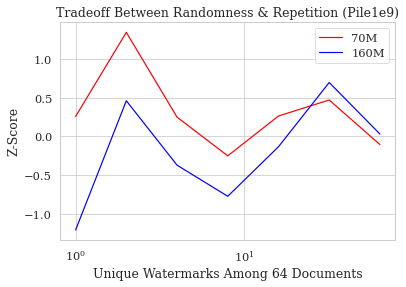

In [18]:
# Create a line plot for each set of y-values
sns.lineplot(x=x, y=experiment_z_scores[0], color='red', label='70M')
ax = sns.lineplot(x=x, y=experiment_z_scores[1], color='blue', label='160M')

# Customize the plot
plt.title('Tradeoff Between Randomness & Repetition (Pile1e9)')
plt.xlabel('Unique Watermarks Among 64 Documents')
plt.ylabel('Z-Score')
plt.legend()

ax.set_xscale("log")

# Show the plot
plt.show()

In [1]:
from transformers import AutoTokenizer

/home/ryan/miniconda3/envs/neoxv4/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")

In [5]:
tokenizer.decode([i + 50000 for i in range(1000)])

' grids debian furthermore dexterity Collectionsoslovilagebj Monteneg strutConnector massacres briefsfetcheduvianolitionFailureemonic flared claimant cures giveaways Substancealions cringe Kul aristocracy Ulsterolatedhousing MIS glared Wilhelmneedslambdabuilders VIS radiator Ghostbusters 436actual herdsçawatching counteringCharge charred warheads iodine Macy041 departures Sins dyed Conceptsgado713 quotations gist Christy antigen Hemp Drawn Bargezvous paternity ardu Anchorage Rik overloaded Username Tammy Nau Cellular waning rodent Worcesterilts Tad dwellings bullish431 retaliate migraine ChevronCHECK donkeycrimSPA Analog marquee HaasBir GDDR Downloads willpower Forth Recorded impossibility Logged Franks Rattinitions cleaners sorely flickering ExaminationcatchingalloweenMsg dunnoFa dysphcrazy.\'\'. mainline cs ptr Wallyigun951 Bigfootfights retrievingJr duplication Explan relational quaint biscuits ado shudder antidotebloodedksh sauces reinvest dispensary Diver 9000student inseparescap 

In [7]:
import numpy as np

In [32]:
random_sequence =  np.random.randint(0, 80, size=10000 * 10)
print(random_sequence.shape)
random_sequence = random_sequence.reshape(-1, 10)
random_sequence.shape
# random_sequence = tokenizer.batch_decode(random_sequence)

(100000,)


(10000, 10)

In [33]:
random_sequence = tokenizer.batch_decode(random_sequence)


In [34]:
np.array(random_sequence).shape

(10000,)

In [35]:
tokenized_again = tokenizer(random_sequence)["input_ids"]

In [36]:
length = [len(i) for i in tokenized_again]
print(np.array(length).mean())

8.6665
